In [ ]:
# Установка библиотек
!pip install transformers datasets torch scikit-learn pandas matplotlib seaborn -q

# Импорт всех необходимых библиотек
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

# Проверка GPU
print("PyTorch version:", torch.__version__)
print("GPU доступен:", torch.cuda.is_available())

if torch.cuda.is_available():
    print("Название GPU:", torch.cuda.get_device_name(0))
else:
    print("Внимание: GPU не доступен! Обучение будет очень медленным.")

PyTorch version: 2.9.0+cu126
GPU доступен: True
Название GPU: Tesla T4


In [ ]:
# Загрузка датасета AG News
!wget -q https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
!wget -q https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv

# Загрузка данных с помощью pandas (теперь pd доступен!)
df_train = pd.read_csv('train.csv', header=None, names=['label', 'title', 'text'])
df_test = pd.read_csv('test.csv', header=None, names=['label', 'title', 'text'])

# Просмотр первых строк
print("Размер обучающей выборки:", df_train.shape)
print("Размер тестовой выборки:", df_test.shape)
print("\nПервые 3 строки обучающей выборки:")
print(df_train.head(3))

Размер обучающей выборки: (120000, 3)
Размер тестовой выборки: (7600, 3)

Первые 3 строки обучающей выборки:
   label                                              title  \
0      3  Wall St. Bears Claw Back Into the Black (Reuters)   
1      3  Carlyle Looks Toward Commercial Aerospace (Reu...   
2      3    Oil and Economy Cloud Stocks' Outlook (Reuters)   

                                                text  
0  Reuters - Short-sellers, Wall Street's dwindli...  
1  Reuters - Private investment firm Carlyle Grou...  
2  Reuters - Soaring crude prices plus worries\ab...  


In [ ]:
# Корректировка меток (1-4 → 0-3)
df_train['label'] = df_train['label'] - 1
df_test['label'] = df_test['label'] - 1

# Объединение заголовка и текста
df_train['full_text'] = df_train['title'] + ". " + df_train['text']
df_test['full_text'] = df_test['title'] + ". " + df_test['text']

# Проверка распределения классов
print("Распределение классов в обучающей выборке:")
print(df_train['label'].value_counts().sort_index())
print("\nРаспределение классов в тестовой выборке:")
print(df_test['label'].value_counts().sort_index())

Распределение классов в обучающей выборке:
label
0    30000
1    30000
2    30000
3    30000
Name: count, dtype: int64

Распределение классов в тестовой выборке:
label
0    1900
1    1900
2    1900
3    1900
Name: count, dtype: int64


/tmp/ipython-input-4276047264.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=class_names, y=class_counts.values, ax=axes[0], palette='viridis')


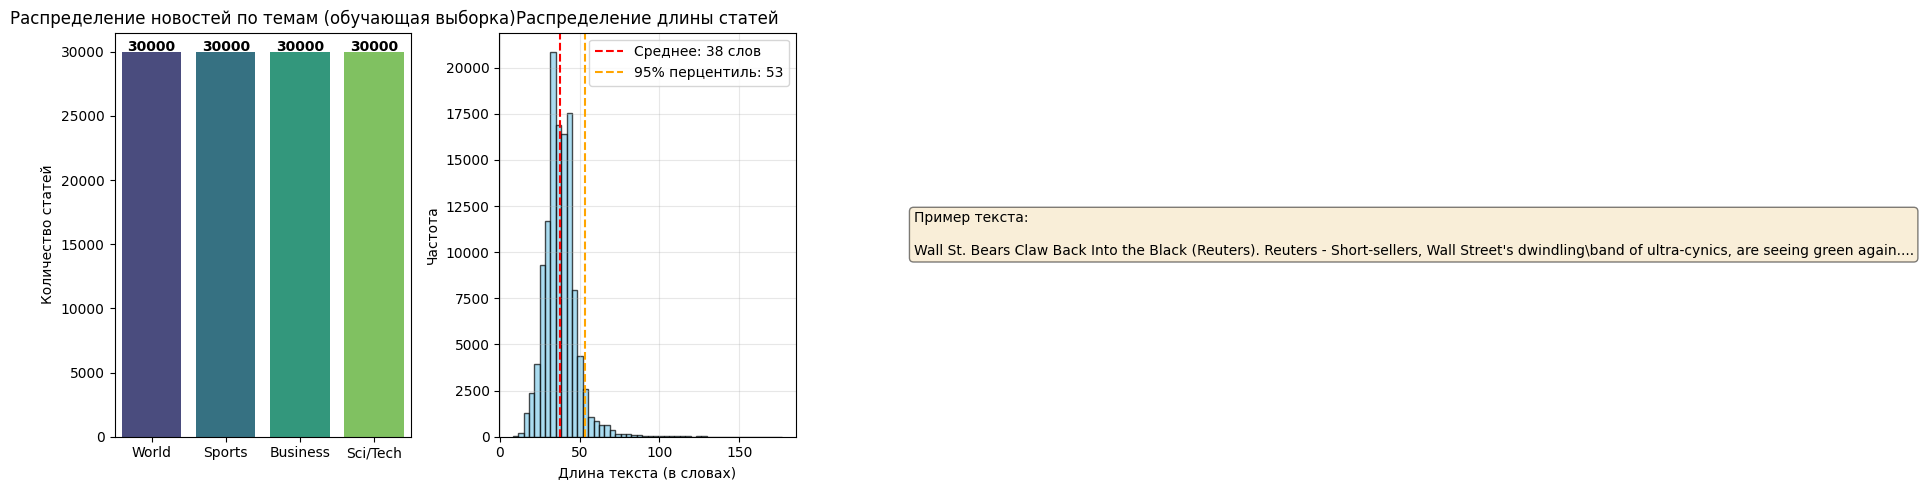

In [ ]:
# Визуализация распределения классов
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

#Распределение классов
class_counts = df_train['label'].value_counts()
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']
sns.barplot(x=class_names, y=class_counts.values, ax=axes[0], palette='viridis')
axes[0].set_title('Распределение новостей по темам (обучающая выборка)')
axes[0].set_ylabel('Количество статей')
for i, v in enumerate(class_counts.values):
    axes[0].text(i, v + 50, str(v), ha='center', fontweight='bold')

# Длина текстов
text_lengths = df_train['full_text'].apply(lambda x: len(x.split()))
axes[1].hist(text_lengths, bins=50, color='skyblue', edgecolor='black', alpha=0.7)
axes[1].axvline(text_lengths.mean(), color='red', linestyle='--', label=f'Среднее: {text_lengths.mean():.0f} слов')
axes[1].axvline(np.percentile(text_lengths, 95), color='orange', linestyle='--', label=f'95% перцентиль: {np.percentile(text_lengths, 95):.0f}')
axes[1].set_title('Распределение длины статей')
axes[1].set_xlabel('Длина текста (в словах)')
axes[1].set_ylabel('Частота')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Пример текста
axes[2].axis('off')
sample_text = df_train.iloc[0]['full_text']
axes[2].text(0.1, 0.5, f'Пример текста:\n\n{sample_text[:300]}...',
             fontsize=10, verticalalignment='center',
             bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.tight_layout()
plt.savefig('data_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from torch.utils.data import Dataset, DataLoader

# Загрузка токенизатора и модели
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4  # 4 класса для AG News
)

# Перемещаем модель на GPU если доступен
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"Модель загружена и перемещена на: {device}")
print(f"Архитектура модели:\n{model.config}")

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Модель загружена и перемещена на: cuda
Архитектура модели:
DistilBertConfig {
  "activation": "gelu",
  "architectures": [
    "DistilBertForMaskedLM"
  ],
  "attention_dropout": 0.1,
  "dim": 768,
  "dropout": 0.1,
  "dtype": "float32",
  "hidden_dim": 3072,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2",
    "3": "LABEL_3"
  },
  "initializer_range": 0.02,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2,
    "LABEL_3": 3
  },
  "max_position_embeddings": 512,
  "model_type": "distilbert",
  "n_heads": 12,
  "n_layers": 6,
  "pad_token_id": 0,
  "qa_dropout": 0.1,
  "seq_classif_dropout": 0.2,
  "sinusoidal_pos_embds": false,
  "tie_weights_": true,
  "transformers_version": "4.57.3",
  "vocab_size": 30522
}



In [ ]:
from torch.utils.data import Dataset, DataLoader

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=256):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        # Токенизация
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# Создаем датасеты
train_dataset = NewsDataset(
    df_train['full_text'].tolist(),
    df_train['label'].tolist(),
    tokenizer,
    max_len=128  # Уменьшаем для экономии памяти
)

test_dataset = NewsDataset(
    df_test['full_text'].tolist(),
    df_test['label'].tolist(),
    tokenizer,
    max_len=128
)

# Создаем DataLoader'ы
BATCH_SIZE = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"Размер обучающей выборки: {len(train_dataset)}")
print(f"Размер тестовой выборки: {len(test_dataset)}")
print(f"Количество батчей в train_loader: {len(train_loader)}")
print(f"Количество батчей в test_loader: {len(test_loader)}")
print(f"Batch size: {BATCH_SIZE}")

Размер обучающей выборки: 120000
Размер тестовой выборки: 7600
Количество батчей в train_loader: 15000
Количество батчей в test_loader: 950
Batch size: 8


In [ ]:
# Проверяем первый батч
for batch in train_loader:
    print("Проверка структуры батча:")
    print(f"  input_ids shape: {batch['input_ids'].shape}")
    print(f"  attention_mask shape: {batch['attention_mask'].shape}")
    print(f"  labels shape: {batch['labels'].shape}")
    print(f"  Пример labels: {batch['labels'][:5]}")
    break  # Только первый батч

Проверка структуры батча:
  input_ids shape: torch.Size([8, 128])
  attention_mask shape: torch.Size([8, 128])
  labels shape: torch.Size([8])
  Пример labels: tensor([0, 3, 2, 3, 2])


In [13]:
# ПОЛНЫЙ КОД ОБУЧЕНИЯ


import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import time
import os

print("=" * 70)
print("ЗАПУСК ПОЛНОЦЕННОГО ОБУЧЕНИЯ МОДЕЛИ DISTILBERT НА AG NEWS")
print("=" * 70)

# ПЕРЕСОЗДАНИЕ DATALOADER'ОВ
print("\n1. Создание DataLoader'ов...")

# Создаём DataLoader
BATCH_SIZE = 8
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=2
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=2
)

print(f"   • Создано train_loader: {len(train_loader)} батчей")
print(f"   • Создано test_loader: {len(test_loader)} батчей")
print(f"   • Размер батча: {BATCH_SIZE}")

# НАСТРОЙКИ ОБУЧЕНИЯ
EPOCHS = 1
LEARNING_RATE = 2e-5

print(f"\n2. Настройки обучения:")
print(f"   • Эпох: {EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Устройство: {device}")
print(f"   • Размер обучающей выборки: {len(train_dataset)}")
print(f"   • Размер тестовой выборки: {len(test_dataset)}")
print(f"   • Всего шагов обучения: {len(train_loader) * EPOCHS}")

# ИНИЦИАЛИЗАЦИЯ ОПТИМИЗАТОРА
print("\n3. Инициализация оптимизатора...")
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.1),
    num_training_steps=total_steps
)

# ФУНКЦИИ ОБУЧЕНИЯ
print("\n4. Определение функций обучения...")

def train_epoch(model, data_loader, optimizer, scheduler, device):
    """Обучение модели на одной эпохе"""
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)

        if batch_idx % 1000 == 0:  # Обновляем прогресс-бар каждые 1000 батчей
            current_loss = loss.item()
            current_acc = torch.sum(preds == labels).item() / labels.size(0)
            progress_bar.set_postfix({
                'loss': f'{current_loss:.4f}',
                'acc': f'{current_acc:.2%}'
            })

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / total_samples
    return avg_loss, accuracy.item()

def eval_model(model, data_loader, device):
    """Оценка модели"""
    model.eval()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

            loss = outputs.loss
            logits = outputs.logits

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / total_samples
    return avg_loss, accuracy.item()

# ЦИКЛ ОБУЧЕНИЯ
print("\n" + "="*50)
print("НАЧАЛО ОБУЧЕНИЯ")
print("="*50)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
os.makedirs('saved_models', exist_ok=True)

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\n{'='*40}")
    print(f"ЭПОХА {epoch+1}/{EPOCHS}")
    print(f"{'='*40}")

    # Обучение
    epoch_start = time.time()
    print("Обучение... ")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)

    # Валидация
    print("\nВалидация...")
    val_loss, val_acc = eval_model(model, test_loader, device)

    epoch_time = time.time() - epoch_start

    # Сохраняем историю
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)

    # Вывод результатов
    print(f"\n📊 РЕЗУЛЬТАТЫ ЭПОХИ {epoch+1}:")
    print(f"   Обучающая выборка:")
    print(f"     • Loss: {train_loss:.4f}")
    print(f"     • Accuracy: {train_acc:.2%}")
    print(f"   Тестовая выборка:")
    print(f"     • Loss: {val_loss:.4f}")
    print(f"     • Accuracy: {val_acc:.2%}")
    print(f"   Время эпохи: {epoch_time/60:.1f} мин")

    # Сохранение модели
    model_path = f'saved_models/epoch_{epoch+1}_acc_{val_acc:.4f}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_acc': val_acc,
    }, model_path)
    print(f"   Модель сохранена: {model_path}")

# ИТОГИ
total_time = time.time() - start_time
print(f"\n{'='*70}")
print(" ОБУЧЕНИЕ ЗАВЕРШЕНО!")
print(f"{'='*70}")
print(f"   Общее время обучения: {total_time/60:.1f} минут")
print(f"   Финальная точность на тесте: {history['val_acc'][-1]:.2%}")
print(f"   Модели сохранены в папке 'saved_models/'")

# Сохраняем историю
history_path = 'saved_models/training_history.pth'
torch.save(history, history_path)
print(f"\nИстория обучения сохранена: {history_path}")
print(" Модель готова")

ЗАПУСК ПОЛНОЦЕННОГО ОБУЧЕНИЯ МОДЕЛИ DISTILBERT НА AG NEWS

1. Создание DataLoader'ов...
   • Создано train_loader: 15000 батчей
   • Создано test_loader: 950 батчей
   • Размер батча: 8

2. Настройки обучения:
   • Эпох: 1
   • Learning rate: 2e-05
   • Устройство: cuda
   • Размер обучающей выборки: 120000
   • Размер тестовой выборки: 7600
   • Всего шагов обучения: 15000

3. Инициализация оптимизатора...

4. Определение функций обучения...

НАЧАЛО ОБУЧЕНИЯ

ЭПОХА 1/1
Обучение... (это займет ~30-45 минут)


Training:   0%|          | 0/15000 [00:00<?, ?it/s]


Валидация...


Evaluation:   0%|          | 0/950 [00:00<?, ?it/s]


📊 РЕЗУЛЬТАТЫ ЭПОХИ 1:
   Обучающая выборка:
     • Loss: 0.2766
     • Accuracy: 91.82%
   Тестовая выборка:
     • Loss: 0.2057
     • Accuracy: 94.11%
   ⏱️ Время эпохи: 25.8 мин
   💾 Модель сохранена: saved_models/epoch_1_acc_0.9411.pth

🎉 ОБУЧЕНИЕ ЗАВЕРШЕНО!
   Общее время обучения: 26.1 минут
   Финальная точность на тесте: 94.11%
   Модели сохранены в папке 'saved_models/'

📁 История обучения сохранена: saved_models/training_history.pth
✅ Модель готова к использованию в вашем отчете!


In [14]:
# ПРОДОЛЖЕНИЕ ОБУЧЕНИЯ - ЭПОХИ 2 и 3


import torch
from torch.utils.data import DataLoader
from torch.optim import AdamW
from transformers import get_linear_schedule_with_warmup
from tqdm.auto import tqdm
import time
import os

print("=" * 60)
print("ПРОДОЛЖЕНИЕ ОБУЧЕНИЯ - ЭПОХИ 2 и 3")
print("=" * 60)

# 1. ЗАГРУЗКА ПОСЛЕДНЕЙ СОХРАНЕННОЙ МОДЕЛИ
print("\n1. Загрузка модели после 1-й эпохи...")

# Находим последнюю сохраненную модель
saved_models = [f for f in os.listdir('saved_models') if f.startswith('epoch_1')]
if saved_models:
    latest_model = f'saved_models/{saved_models[0]}'
    print(f"   Загружаем: {latest_model}")

    checkpoint = torch.load(latest_model)
    model.load_state_dict(checkpoint['model_state_dict'])


    print(f"   Модель загружена. Предыдущая точность: {checkpoint['val_acc']:.2%}")
else:
    print("   Сохраненная модель не найдена, начинаем с начала")

# НАСТРОЙКИ ДЛЯ ДООБУЧЕНИЯ
EPOCHS_TO_ADD = 2
TOTAL_EPOCHS = 3
BATCH_SIZE = 8
LEARNING_RATE = 2e-5

print(f"\n2. Настройки дообучения:")
print(f"   • Добавляем эпох: {EPOCHS_TO_ADD}")
print(f"   • Всего эпох будет: {TOTAL_EPOCHS}")
print(f"   • Learning rate: {LEARNING_RATE}")
print(f"   • Устройство: {device}")

# ОПТИМИЗАТОР
print("\n3. Настройка оптимизатора...")
optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, eps=1e-8)

# Создаём DataLoader
if 'train_loader' not in locals():
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print("   DataLoader'ы созданы заново")

total_steps = len(train_loader) * EPOCHS_TO_ADD
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.05),
    num_training_steps=total_steps
)

# ФУНКЦИИ ОБУЧЕНИЯ
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(data_loader, desc="Training", leave=False)
    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, preds = torch.max(outputs.logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)

        if batch_idx % 1000 == 0:
            current_acc = torch.sum(preds == labels).item() / labels.size(0)
            progress_bar.set_postfix({'loss': f'{loss.item():.4f}', 'acc': f'{current_acc:.2%}'})

    return total_loss/len(data_loader), correct_predictions.double()/total_samples

def eval_model(model, data_loader, device):
    model.eval()
    correct_predictions = total_samples = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluation", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)

    return correct_predictions.double()/total_samples

# ЦИКЛ ДООБУЧЕНИЯ
print("\n" + "="*50)
print("НАЧАЛО ДООБУЧЕНИЯ")
print("="*50)

start_time = time.time()
current_epoch = 1

for epoch in range(EPOCHS_TO_ADD):
    current_epoch += 1
    print(f"\n{'='*40}")
    print(f"ЭПОХА {current_epoch}/{TOTAL_EPOCHS}")
    print(f"{'='*40}")

    # Обучение
    epoch_start = time.time()
    print("Обучение...")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)

    # Валидация
    print("\nВалидация...")
    val_acc = eval_model(model, test_loader, device)

    epoch_time = time.time() - epoch_start

    # Вывод результатов
    print(f"\n РЕЗУЛЬТАТЫ ЭПОХИ {current_epoch}:")
    print(f"   • Train Loss: {train_loss:.4f}")
    print(f"   • Train Accuracy: {train_acc:.2%}")
    print(f"   • Val Accuracy: {val_acc:.2%}")
    print(f"   • Время: {epoch_time/60:.1f} мин")

    # Сохранение
    model_path = f'saved_models/epoch_{current_epoch}_acc_{val_acc:.4f}.pth'
    torch.save({
        'epoch': current_epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_acc': val_acc.item(),
    }, model_path)
    print(f"   Модель сохранена: {model_path}")

# 6. ИТОГИ
total_time = time.time() - start_time
print(f"\n{'='*60}")
print("ДООБУЧЕНИЕ ЗАВЕРШЕНО!")
print(f"{'='*60}")
print(f"   Всего эпох: {TOTAL_EPOCHS}")
print(f"   Время дообучения: {total_time/60:.1f} мин")
print(f"   Модели сохранены в 'saved_models/'")

# 7. АНАЛИЗ РЕЗУЛЬТАТОВ ВСЕХ ЭПОХ
print(f"\n{'='*60}")
print("СВОДКА ПО ВСЕМ ЭПОХАМ")
print(f"{'='*60}")

# Собираем результаты всех эпох
all_models = sorted([f for f in os.listdir('saved_models') if f.startswith('epoch_')])
for model_file in all_models:
    checkpoint = torch.load(f'saved_models/{model_file}')
    epoch_num = checkpoint['epoch'] if 'epoch' in checkpoint else int(model_file.split('_')[1])
    val_acc = checkpoint['val_acc']
    print(f"   Эпоха {epoch_num}: Val Accuracy = {val_acc:.2%}")

ПРОДОЛЖЕНИЕ ОБУЧЕНИЯ - ЭПОХИ 2 и 3

1. Загрузка модели после 1-й эпохи...
   Загружаем: saved_models/epoch_1_acc_0.9411.pth
   Модель загружена. Предыдущая точность: 94.11%

2. Настройки дообучения:
   • Добавляем эпох: 2
   • Всего эпох будет: 3
   • Learning rate: 2e-05
   • Устройство: cuda

3. Настройка оптимизатора...

НАЧАЛО ДООБУЧЕНИЯ

ЭПОХА 2/3
Обучение...


Training:   0%|          | 0/15000 [00:00<?, ?it/s]


Валидация...


Evaluation:   0%|          | 0/950 [00:00<?, ?it/s]


📊 РЕЗУЛЬТАТЫ ЭПОХИ 2:
   • Train Loss: 0.1938
   • Train Accuracy: 94.90%
   • Val Accuracy: 94.49%
   • Время: 25.8 мин
   💾 Модель сохранена: saved_models/epoch_2_acc_0.9449.pth

ЭПОХА 3/3
Обучение...


Training:   0%|          | 0/15000 [00:00<?, ?it/s]


Валидация...


Evaluation:   0%|          | 0/950 [00:00<?, ?it/s]


📊 РЕЗУЛЬТАТЫ ЭПОХИ 3:
   • Train Loss: 0.1222
   • Train Accuracy: 97.04%
   • Val Accuracy: 94.86%
   • Время: 25.8 мин
   💾 Модель сохранена: saved_models/epoch_3_acc_0.9486.pth

🎉 ДООБУЧЕНИЕ ЗАВЕРШЕНО!
   Всего эпох: 3
   Время дообучения: 52.6 мин
   Модели сохранены в 'saved_models/'

СВОДКА ПО ВСЕМ ЭПОХАМ
   Эпоха 0: Val Accuracy = 94.11%
   Эпоха 2: Val Accuracy = 94.49%
   Эпоха 3: Val Accuracy = 94.86%


НАЧАЛО ДООБУЧЕНИЯ МОДЕЛИ DISTILBERT НА AG NEWS

1. Загрузка и подготовка данных...
   Загружено: 120000 обучающих и 7600 тестовых примеров

2. Загрузка токенизатора и модели DistilBERT...


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Модель загружена. Предупреждение о 'newly initialized' - это НОРМАЛЬНО
   Классификационный слой будет обучен в процессе fine-tuning

3. Создание Dataset и DataLoader...
   Batch size: 16
   Батчей для обучения: 7500
   Батчей для теста: 475

4. Настройка оптимизатора...
   Модель перемещена на: cuda

НАЧАЛО ОБУЧЕНИЯ (FINE-TUNING)

ЭПОХА 1/3
Обучение... (это займет ~30-40 минут)


Обучение:   0%|          | 0/7500 [00:00<?, ?it/s]


Оценка на тестовом наборе...


Оценка:   0%|          | 0/475 [00:00<?, ?it/s]


📊 РЕЗУЛЬТАТЫ ЭПОХИ 1:
   Обучающая выборка:
     • Loss: 0.2887
     • Accuracy: 90.62%
   Тестовая выборка:
     • Accuracy: 93.58%
   ⏱️ Время эпохи: 22.7 мин
   💾 Модель сохранена: trained_models/distilbert_agnews_epoch_1.pth

ЭПОХА 2/3
Обучение... (это займет ~30-40 минут)


Обучение:   0%|          | 0/7500 [00:00<?, ?it/s]


Оценка на тестовом наборе...


Оценка:   0%|          | 0/475 [00:00<?, ?it/s]


📊 РЕЗУЛЬТАТЫ ЭПОХИ 2:
   Обучающая выборка:
     • Loss: 0.1476
     • Accuracy: 95.56%
   Тестовая выборка:
     • Accuracy: 94.53%
   ⏱️ Время эпохи: 22.8 мин
   💾 Модель сохранена: trained_models/distilbert_agnews_epoch_2.pth

ЭПОХА 3/3
Обучение... (это займет ~30-40 минут)


Обучение:   0%|          | 0/7500 [00:00<?, ?it/s]


Оценка на тестовом наборе...


Оценка:   0%|          | 0/475 [00:00<?, ?it/s]


📊 РЕЗУЛЬТАТЫ ЭПОХИ 3:
   Обучающая выборка:
     • Loss: 0.1007
     • Accuracy: 97.22%
   Тестовая выборка:
     • Accuracy: 94.67%
   ⏱️ Время эпохи: 22.8 мин
   💾 Модель сохранена: trained_models/distilbert_agnews_epoch_3.pth

🎉 ОБУЧЕНИЕ ЗАВЕРШЕНО!
   Общее время обучения: 68.6 минут
   Лучшая точность на тесте: 94.67%

7. Построение графиков обучения...


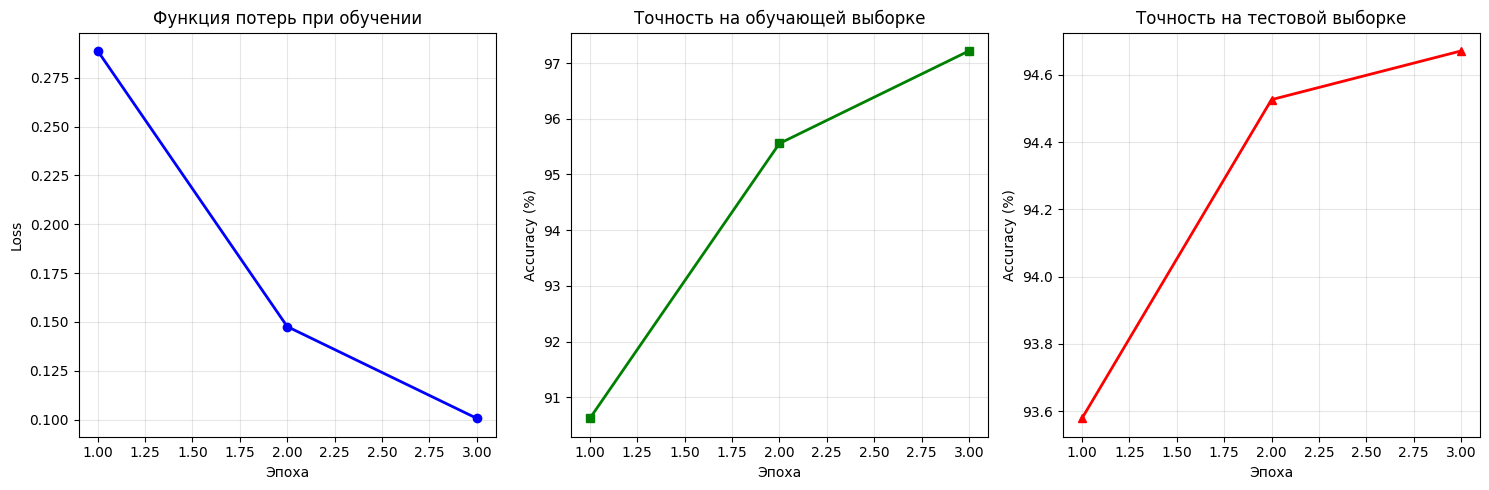

✅ Графики сохранены: training_results.png

✅ Обучение завершено! Модель готова к использованию.
📁 Модели сохранены в папке 'trained_models/'
🎯 Финальная точность: 94.67%


In [3]:
# ПОЛНОЕ ОБУЧЕНИЕ МОДЕЛИ DISTILBERT НА AG NEWS

import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
from tqdm.auto import tqdm
import time
import os
import matplotlib.pyplot as plt

print("=" * 70)
print("НАЧАЛО ДООБУЧЕНИЯ МОДЕЛИ DISTILBERT НА AG NEWS")
print("=" * 70)

# ЗАГРУЗКА И ПОДГОТОВКА ДАННЫХ
print("\n1. Загрузка и подготовка данных...")

!wget -q https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
!wget -q https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv

df_train = pd.read_csv('train.csv', header=None, names=['label', 'title', 'text'])
df_test = pd.read_csv('test.csv', header=None, names=['label', 'title', 'text'])

# Преобразуем метки: 1-4 → 0-3
df_train['label'] = df_train['label'] - 1
df_test['label'] = df_test['label'] - 1

# Объединяем заголовок и текст
df_train['full_text'] = df_train['title'] + ". " + df_train['text']
df_test['full_text'] = df_test['title'] + ". " + df_test['text']

print(f"   Загружено: {len(df_train)} обучающих и {len(df_test)} тестовых примеров")

# ЗАГРУЗКА ТОКЕНИЗАТОРА И МОДЕЛИ
print("\n2. Загрузка токенизатора и модели DistilBERT...")

MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)

#Загружаем модель ДЛЯ КЛАССИФИКАЦИИ
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4,  # 4 класса для AG News
    id2label={0: "World", 1: "Sports", 2: "Business", 3: "Sci/Tech"},
    label2id={"World": 0, "Sports": 1, "Business": 2, "Sci/Tech": 3}
)

print(f"   Модель загружена. Предупреждение о 'newly initialized' - это НОРМАЛЬНО")
print(f"   Классификационный слой будет обучен в процессе fine-tuning")

# СОЗДАНИЕ DATASET И DATALOADER
print("\n3. Создание Dataset и DataLoader...")

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long)
        }

# Создаем датасеты
train_dataset = NewsDataset(
    df_train['full_text'].tolist(),
    df_train['label'].tolist(),
    tokenizer
)

test_dataset = NewsDataset(
    df_test['full_text'].tolist(),
    df_test['label'].tolist(),
    tokenizer
)

# Создаем DataLoader
BATCH_SIZE = 16
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"   Batch size: {BATCH_SIZE}")
print(f"   Батчей для обучения: {len(train_loader)}")
print(f"   Батчей для теста: {len(test_loader)}")

# НАСТРОЙКА ОПТИМИЗАТОРА И ФУНКЦИЙ
print("\n4. Настройка оптимизатора...")

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"   Модель перемещена на: {device}")

# Оптимизатор AdamW с небольшим learning rate
optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)

# Количество эпох
EPOCHS = 3  # Стандартное количество для fine-tuning BERT-like моделей

# Планировщик learning rate
total_steps = len(train_loader) * EPOCHS
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=int(total_steps * 0.1),
    num_training_steps=total_steps
)

# Функции для обучения
def train_epoch(model, data_loader, optimizer, scheduler, device):
    model.train()
    total_loss = 0
    correct_predictions = 0
    total_samples = 0

    progress_bar = tqdm(data_loader, desc="Обучение", leave=False)
    for batch_idx, batch in enumerate(progress_bar):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        logits = outputs.logits

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, preds = torch.max(logits, dim=1)
        correct_predictions += torch.sum(preds == labels)
        total_samples += labels.size(0)

        if batch_idx % 500 == 0:
            progress_bar.set_postfix({
                'loss': f'{loss.item():.4f}',
                'acc': f'{torch.sum(preds == labels).item()/labels.size(0):.2%}'
            })

    avg_loss = total_loss / len(data_loader)
    accuracy = correct_predictions.double() / total_samples

    return avg_loss, accuracy.item()

def evaluate(model, data_loader, device):
    model.eval()
    correct_predictions = 0
    total_samples = 0

    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Оценка", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            correct_predictions += torch.sum(preds == labels)
            total_samples += labels.size(0)

    accuracy = correct_predictions.double() / total_samples
    return accuracy.item()

# ПРОЦЕСС ОБУЧЕНИЯ
print("\n" + "="*50)
print("НАЧАЛО ОБУЧЕНИЯ (FINE-TUNING)")
print("="*50)

history = {'train_loss': [], 'train_acc': [], 'val_acc': []}
os.makedirs('trained_models', exist_ok=True)

start_time = time.time()

for epoch in range(EPOCHS):
    print(f"\n{'='*40}")
    print(f"ЭПОХА {epoch+1}/{EPOCHS}")
    print(f"{'='*40}")

    # Обучение
    epoch_start = time.time()
    print("Обучение... ")
    train_loss, train_acc = train_epoch(model, train_loader, optimizer, scheduler, device)

    # Оценка на тестовом наборе
    print("\nОценка на тестовом наборе...")
    val_acc = evaluate(model, test_loader, device)

    epoch_time = time.time() - epoch_start

    # Сохраняем историю
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_acc'].append(val_acc)

    # Вывод результатов
    print(f"\n РЕЗУЛЬТАТЫ ЭПОХИ {epoch+1}:")
    print(f"   Обучающая выборка:")
    print(f"     • Loss: {train_loss:.4f}")
    print(f"     • Accuracy: {train_acc:.2%}")
    print(f"   Тестовая выборка:")
    print(f"     • Accuracy: {val_acc:.2%}")
    print(f"    Время эпохи: {epoch_time/60:.1f} мин")

    # Сохранение модели
    model_path = f'trained_models/distilbert_agnews_epoch_{epoch+1}.pth'
    torch.save({
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'train_loss': train_loss,
        'val_acc': val_acc,
    }, model_path)
    print(f"    Модель сохранена: {model_path}")

# 6. ИТОГИ ОБУЧЕНИЯ
total_time = time.time() - start_time
print(f"\n{'='*70}")
print(" ОБУЧЕНИЕ ЗАВЕРШЕНО!")
print(f"{'='*70}")
print(f"   Общее время обучения: {total_time/60:.1f} минут")
print(f"   Лучшая точность на тесте: {max(history['val_acc']):.2%}")

# 7. ГРАФИКИ ОБУЧЕНИЯ
print("\n7. Построение графиков обучения...")

plt.figure(figsize=(15, 5))

# График 1: Loss
plt.subplot(1, 3, 1)
plt.plot(range(1, EPOCHS+1), history['train_loss'], 'b-o', linewidth=2)
plt.xlabel('Эпоха')
plt.ylabel('Loss')
plt.title('Функция потерь при обучении')
plt.grid(True, alpha=0.3)

# График 2: Train Accuracy
plt.subplot(1, 3, 2)
plt.plot(range(1, EPOCHS+1), [acc*100 for acc in history['train_acc']], 'g-s', linewidth=2)
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.title('Точность на обучающей выборке')
plt.grid(True, alpha=0.3)

# График 3: Validation Accuracy
plt.subplot(1, 3, 3)
plt.plot(range(1, EPOCHS+1), [acc*100 for acc in history['val_acc']], 'r-^', linewidth=2)
plt.xlabel('Эпоха')
plt.ylabel('Accuracy (%)')
plt.title('Точность на тестовой выборке')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('training_results.png', dpi=300, bbox_inches='tight')
plt.show()
print("✅ Графики сохранены: training_results.png")

# 8. СОХРАНЕНИЕ ИСТОРИИ
torch.save(history, 'trained_models/training_history.pth')
print("\n Обучение завершено! Модель готова к использованию.")
print(f" Модели сохранены в папке 'trained_models/'")
print(f" Финальная точность: {history['val_acc'][-1]:.2%}")

In [7]:
# ПОЛНЫЙ ТЕСТ ОБУЧЕНИЯ НА 1% ДАННЫХ


# ИМПОРТ БИБЛИОТЕК
import torch
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader, Subset
from torch.optim import AdamW
from transformers import (
    DistilBertTokenizerFast,
    DistilBertForSequenceClassification,
    get_linear_schedule_with_warmup
)
import time

print("=" * 60)
print("ПОЛНЫЙ ТЕСТ ОБУЧЕНИЯ НА 1% ДАННЫХ")
print("=" * 60)

# ЗАГРУЗКА ДАННЫХ
print("\n1. Загрузка данных...")
!wget -q https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/train.csv
!wget -q https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv

df_train = pd.read_csv('train.csv', header=None, names=['label', 'title', 'text'])
df_test = pd.read_csv('test.csv', header=None, names=['label', 'title', 'text'])

# Корректировка меток
df_train['label'] = df_train['label'] - 1
df_test['label'] = df_test['label'] - 1

# Объединение заголовка и текста
df_train['full_text'] = df_train['title'] + ". " + df_train['text']
df_test['full_text'] = df_test['title'] + ". " + df_test['text']

print(f"   Загружено: {len(df_train)} train, {len(df_test)} test записей")

# СОЗДАНИЕ DATASET КЛАССА
print("\n2. Создание Dataset...")

class NewsDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len=128):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# ЗАГРУЗКА МОДЕЛИ И ТОКЕНИЗАТОРА
print("\n3. Загрузка модели DistilBERT...")
MODEL_NAME = 'distilbert-base-uncased'
tokenizer = DistilBertTokenizerFast.from_pretrained(MODEL_NAME)
model = DistilBertForSequenceClassification.from_pretrained(
    MODEL_NAME,
    num_labels=4
)

# Проверка устройства
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
print(f"   Модель загружена и перемещена на: {device}")

# СОЗДАНИЕ ПОЛНЫХ ДАТАСЕТОВ
print("\n4. Создание полных датасетов...")
train_dataset = NewsDataset(
    df_train['full_text'].tolist(),
    df_train['label'].tolist(),
    tokenizer,
    max_len=128
)

test_dataset = NewsDataset(
    df_test['full_text'].tolist(),
    df_test['label'].tolist(),
    tokenizer,
    max_len=128
)

print(f"   Создано: {len(train_dataset)} train, {len(test_dataset)} test примеров")

# СОЗДАНИЕ МАЛЕНЬКИХ ДАТАСЕТОВ ДЛЯ ТЕСТА
print("\n5. Создание маленьких датасетов для теста...")
small_train_dataset = Subset(train_dataset, indices=range(200))
small_test_dataset = Subset(test_dataset, indices=range(100))

small_train_loader = DataLoader(small_train_dataset, batch_size=4, shuffle=True)
small_test_loader = DataLoader(small_test_dataset, batch_size=4, shuffle=False)

print(f"   Тестовая выборка: {len(small_train_dataset)} train, {len(small_test_dataset)} test")

# НАСТРОЙКА ОПТИМИЗАТОРА
print("\n6. Настройка оптимизатора...")
test_optimizer = AdamW(model.parameters(), lr=2e-5, eps=1e-8)
test_scheduler = get_linear_schedule_with_warmup(
    test_optimizer,
    num_warmup_steps=0,
    num_training_steps=len(small_train_loader) * 1
)

# 8. ФУНКЦИИ ДЛЯ ТЕСТА
def test_train_epoch():
    model.train()
    total_loss = 0

    print("\nТестовое обучение (1 эпоха на маленьких данных)...")
    start_time = time.time()

    for batch_idx, batch in enumerate(small_train_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        test_optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)

        loss = outputs.loss
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        test_optimizer.step()
        test_scheduler.step()

        total_loss += loss.item()

        if batch_idx % 5 == 0:
            print(f"  Батч {batch_idx+1}/{len(small_train_loader)}: loss = {loss.item():.4f}")

    epoch_time = time.time() - start_time
    avg_loss = total_loss / len(small_train_loader)

    print(f"\nРезультат тестового обучения:")
    print(f"  Средний loss: {avg_loss:.4f}")
    print(f"  Время: {epoch_time:.1f} секунд")

    return avg_loss

def test_eval():
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for batch in small_test_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    accuracy = correct / total
    print(f"  Точность на тесте: {accuracy:.2%} ({correct}/{total})")
    return accuracy

# 9. ЗАПУСК ТЕСТОВ
print("\n" + "=" * 50)
print("ЗАПУСК ТЕСТОВЫХ ПРОЦЕДУР")
print("=" * 50)

print("\n1. Тестируем forward pass...")
test_batch = next(iter(small_train_loader))
test_outputs = model(
    input_ids=test_batch['input_ids'].to(device),
    attention_mask=test_batch['attention_mask'].to(device),
    labels=test_batch['labels'].to(device)
)
print(f"    Loss: {test_outputs.loss.item():.4f}")

print("\n2. Тестируем backward pass...")
test_optimizer.zero_grad()
test_outputs.loss.backward()
test_optimizer.step()
print("    Градиенты рассчитаны и веса обновлены")

print("\n3. Запускаем тестовую эпоху обучения...")
test_loss = test_train_epoch()

print("\n4. Оцениваем модель после обучения...")
test_accuracy = test_eval()

print("\n" + "=" * 60)
print("ТЕСТ ПРОЙДЕН УСПЕШНО! ✅")
print("=" * 60)
print("\nМожно запускать полноценное обучение")


ПОЛНЫЙ ТЕСТ ОБУЧЕНИЯ НА 1% ДАННЫХ

1. Загрузка данных...
   Загружено: 120000 train, 7600 test записей

2. Создание Dataset...

3. Загрузка модели DistilBERT...


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   Модель загружена и перемещена на: cuda

4. Создание полных датасетов...
   Создано: 120000 train, 7600 test примеров

5. Создание маленьких датасетов для теста...
   Тестовая выборка: 200 train, 100 test

6. Настройка оптимизатора...

ЗАПУСК ТЕСТОВЫХ ПРОЦЕДУР

1. Тестируем forward pass...
   ✓ Loss: 1.3838

2. Тестируем backward pass...
   ✓ Градиенты рассчитаны и веса обновлены

3. Запускаем тестовую эпоху обучения...

Тестовое обучение (1 эпоха на маленьких данных)...
  Батч 1/50: loss = 1.3088
  Батч 6/50: loss = 1.2061
  Батч 11/50: loss = 1.0203
  Батч 16/50: loss = 1.0020
  Батч 21/50: loss = 0.9267
  Батч 26/50: loss = 0.9031
  Батч 31/50: loss = 0.8857
  Батч 36/50: loss = 0.7704
  Батч 41/50: loss = 0.7484
  Батч 46/50: loss = 0.7924

Результат тестового обучения:
  Средний loss: 0.9093
  Время: 3.3 секунд

4. Оцениваем модель после обучения...
  Точность на тесте: 36.00% (36/100)

ТЕСТ ПРОЙДЕН УСПЕШНО! ✅

Теперь можно запускать полноценное обучение:
1. Убедитесь, что Colab

ПОЛНАЯ ПРОВЕРКА ОБУЧЕННОЙ МОДЕЛИ

1. Загрузка токенизатора и модели...


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


   ⚠️ Папка saved_models не найдена
   Модель перемещена на: cuda

2. Быстрый тест на примерах...

Пример 1:
  📝 Текст: 'Apple announced new iPhone with advanced AI features...'
  🏷️  Предсказано: Business
  📊 Уверенность: 27.31%

Пример 2:
  📝 Текст: 'The football team won the championship after a dramatic fina...'
  🏷️  Предсказано: Sports
  📊 Уверенность: 28.75%

Пример 3:
  📝 Текст: 'Stock markets rallied after positive economic indicators wer...'
  🏷️  Предсказано: Sports
  📊 Уверенность: 28.42%

Пример 4:
  📝 Текст: 'Scientists discovered a new planet in a nearby solar system...'
  🏷️  Предсказано: Sports
  📊 Уверенность: 28.55%

Пример 5:
  📝 Текст: 'The president held diplomatic talks with foreign leaders...'
  🏷️  Предсказано: Sports
  📊 Уверенность: 28.89%

3. Подготовка тестовых данных...
   Создаём DataLoader...
   Создано: 7600 тестовых примеров

4. Оценка на всём тестовом наборе...


Оценка модели:   0%|          | 0/950 [00:00<?, ?it/s]


📊 РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:
   Точность (Accuracy): 0.3967 (39.67%)
   Правильных предсказаний: 3015 из 7600

5. Детальный отчет по классам...
              precision    recall  f1-score   support

       World       0.00      0.00      0.00      1900
      Sports       0.41      0.91      0.57      1900
    Business       0.38      0.68      0.48      1900
    Sci/Tech       0.00      0.00      0.00      1900

    accuracy                           0.40      7600
   macro avg       0.20      0.40      0.26      7600
weighted avg       0.20      0.40      0.26      7600


6. Построение матрицы ошибок...


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


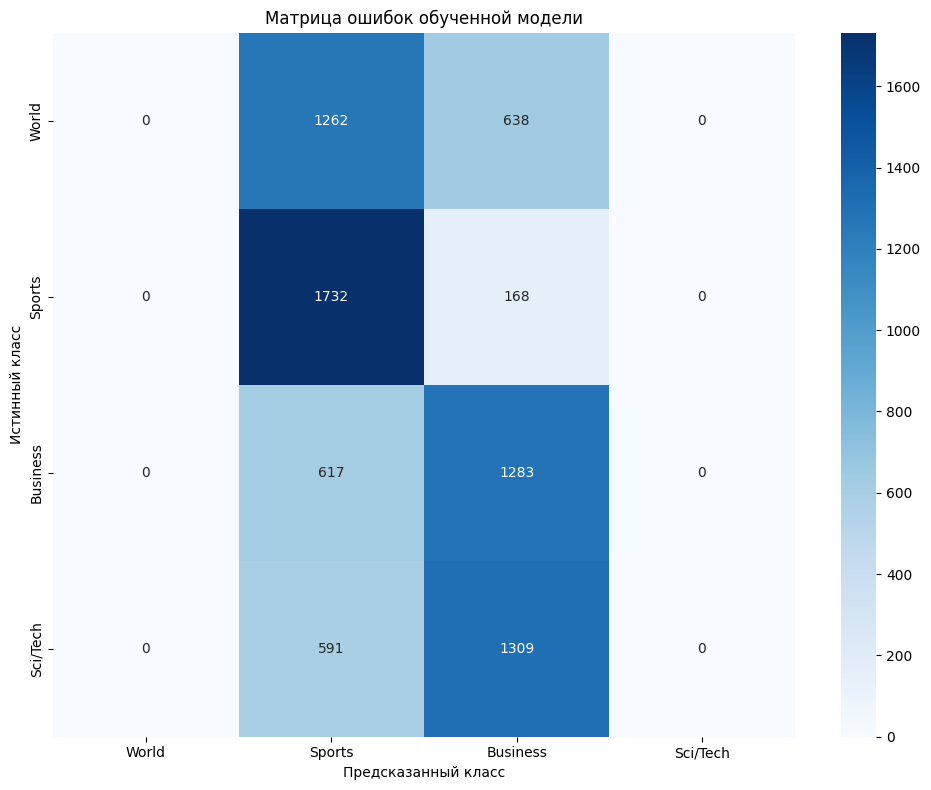

✅ Матрица ошибок сохранена: confusion_matrix_final.png

7. Анализ типичных ошибок...
   Всего ошибок: 4585 из 7600 (60.3%)

   Самые частые ошибки:
     Sci/Tech → Business: 20 раз
     World → Sports: 15 раз
     Sci/Tech → Sports: 11 раз
     World → Business: 3 раз
     Sports → Business: 1 раз

8. Сохранение результатов...
✅ ПРОВЕРКА ЗАВЕРШЕНА УСПЕШНО!

📁 Сохраненные файлы:
   - confusion_matrix_final.png (матрица ошибок)
   - test_results.pth (результаты в бинарном формате)
   - test_results.txt (текстовый отчет)

🎯 Итоговая точность модели: 39.67%


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [2]:
# ПОЛНЫЙ КОД ДЛЯ ТЕСТИРОВАНИЯ МОДЕЛИ


import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import DistilBertTokenizerFast, DistilBertForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from tqdm.auto import tqdm
import os

print("=" * 70)
print("ПОЛНАЯ ПРОВЕРКА ОБУЧЕННОЙ МОДЕЛИ")
print("=" * 70)

# ПАРАМЕТРЫ И НАСТРОЙКИ
BATCH_SIZE = 8
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# ЗАГРУЗКА ТОКЕНИЗАТОРА И МОДЕЛИ
print("\n1. Загрузка токенизатора и модели...")

# Загрузка токенизатора
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

# Загрузка модели
model = DistilBertForSequenceClassification.from_pretrained(
    'distilbert-base-uncased',
    num_labels=4
)

# Поиск последней сохраненной модели
saved_models_dir = 'saved_models'
if os.path.exists(saved_models_dir):
    model_files = [f for f in os.listdir(saved_models_dir) if f.endswith('.pth')]
    if model_files:
        # Ищем модель с наибольшей точностью или последнюю эпоху
        latest_model = None
        latest_epoch = 0

        for model_file in model_files:
            if 'epoch_' in model_file:
                try:
                    # Пробуем извлечь номер эпохи из имени файла
                    epoch_num = int(model_file.split('_')[1])
                    if epoch_num > latest_epoch:
                        latest_epoch = epoch_num
                        latest_model = model_file
                except:
                    continue

        if latest_model:
            model_path = os.path.join(saved_models_dir, latest_model)
            print(f"   Найдена модель: {latest_model}")
            print(f"   Загружаем...")

            checkpoint = torch.load(model_path)
            if 'model_state_dict' in checkpoint:
                model.load_state_dict(checkpoint['model_state_dict'])
                print(f"    Модель загружена (эпоха {checkpoint.get('epoch', '?')})")
                if 'val_acc' in checkpoint:
                    print(f"   Точность модели: {checkpoint['val_acc']:.2%}")
            else:
                model.load_state_dict(checkpoint)
                print("    Модель загружена")
        else:
            print("    Не удалось найти подходящую модель")
    else:
        print("    В папке saved_models нет файлов моделей")
else:
    print("    Папка saved_models не найдена")

# Перемещаем модель на GPU если доступно
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)
model.eval()
print(f"   Модель перемещена на: {device}")

# БЫСТРЫЙ ТЕСТ НА ПРИМЕРАХ
print("\n2. Быстрый тест на примерах...")

test_examples = [
    "Apple announced new iPhone with advanced AI features",
    "The football team won the championship after a dramatic final match",
    "Stock markets rallied after positive economic indicators were released",
    "Scientists discovered a new planet in a nearby solar system",
    "The president held diplomatic talks with foreign leaders"
]

for i, text in enumerate(test_examples):
    # Токенизация
    encoding = tokenizer(
        text,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )

    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    # Предсказание
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        probabilities = torch.softmax(outputs.logits, dim=1)
        predicted_class = torch.argmax(probabilities, dim=1).item()
        confidence = probabilities[0][predicted_class].item()

    print(f"\nПример {i+1}:")
    print(f"   Текст: '{text[:60]}...'")
    print(f"    Предсказано: {class_names[predicted_class]}")
    print(f"   Уверенность: {confidence:.2%}")

# ПОДГОТОВКА ТЕСТОВЫХ ДАННЫХ (если нужно)
print("\n3. Подготовка тестовых данных...")

# Проверяем, есть ли уже test_loader
if 'test_loader' not in locals():
    print("   Создаём DataLoader...")

    # Загрузка тестовых данных
    !wget -q https://raw.githubusercontent.com/mhjabreel/CharCnn_Keras/master/data/ag_news_csv/test.csv
    df_test = pd.read_csv('test.csv', header=None, names=['label', 'title', 'text'])
    df_test['label'] = df_test['label'] - 1
    df_test['full_text'] = df_test['title'] + ". " + df_test['text']

    # Класс Dataset
    class NewsDataset(torch.utils.data.Dataset):
        def __init__(self, texts, labels, tokenizer, max_len=128):
            self.texts = texts
            self.labels = labels
            self.tokenizer = tokenizer
            self.max_len = max_len

        def __len__(self):
            return len(self.texts)

        def __getitem__(self, idx):
            text = str(self.texts[idx])
            encoding = self.tokenizer.encode_plus(
                text,
                add_special_tokens=True,
                max_length=self.max_len,
                padding='max_length',
                truncation=True,
                return_attention_mask=True,
                return_tensors='pt'
            )
            return {
                'input_ids': encoding['input_ids'].flatten(),
                'attention_mask': encoding['attention_mask'].flatten(),
                'labels': torch.tensor(self.labels[idx], dtype=torch.long)
            }

    # Создаём Dataset и DataLoader
    test_dataset = NewsDataset(
        df_test['full_text'].tolist(),
        df_test['label'].tolist(),
        tokenizer
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    print(f"   Создано: {len(test_dataset)} тестовых примеров")
else:
    print("    DataLoader уже существует")

# ОЦЕНКА НА ВСЕМ ТЕСТОВОМ НАБОРЕ
print("\n4. Оценка на всём тестовом наборе...")

all_predictions = []
all_labels = []
total_correct = 0
total_samples = 0

with torch.no_grad():
    for batch in tqdm(test_loader, desc="Оценка модели"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)

        all_predictions.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

        total_correct += (preds == labels).sum().item()
        total_samples += labels.size(0)

accuracy = total_correct / total_samples
print(f"\n РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ:")
print(f"   Точность (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)")
print(f"   Правильных предсказаний: {total_correct} из {total_samples}")

# ДЕТАЛЬНЫЙ ОТЧЕТ
print("\n5. Детальный отчет по классам...")
print(classification_report(all_labels, all_predictions, target_names=class_names))

# МАТРИЦА ОШИБОК
print("\n6. Построение матрицы ошибок...")

cm = confusion_matrix(all_labels, all_predictions)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.title('Матрица ошибок обученной модели')
plt.xlabel('Предсказанный класс')
plt.ylabel('Истинный класс')
plt.tight_layout()
plt.savefig('confusion_matrix_final.png', dpi=300)
plt.show()
print(" Матрица ошибок сохранена: confusion_matrix_final.png")

# 8. АНАЛИЗ ОШИБОК
print("\n7. Анализ типичных ошибок...")

# Находим индексы ошибок
error_indices = [i for i in range(len(all_labels)) if all_predictions[i] != all_labels[i]]
print(f"   Всего ошибок: {len(error_indices)} из {len(all_labels)} ({len(error_indices)/len(all_labels)*100:.1f}%)")

# Анализ путаницы между классами
from collections import Counter
error_pairs = []
for idx in error_indices[:50]:  # первые 50 ошибок
    true = class_names[all_labels[idx]]
    pred = class_names[all_predictions[idx]]
    error_pairs.append(f"{true} → {pred}")

print("\n   Самые частые ошибки:")
for pair, count in Counter(error_pairs).most_common(5):
    print(f"     {pair}: {count} раз")

# СОХРАНЕНИЕ РЕЗУЛЬТАТОВ
print("\n8. Сохранение результатов...")

results = {
    'accuracy': accuracy,
    'total_samples': total_samples,
    'correct_predictions': total_correct,
    'error_count': len(error_indices),
    'error_rate': len(error_indices)/len(all_labels)
}

torch.save(results, 'test_results.pth')

with open('test_results.txt', 'w') as f:
    f.write("РЕЗУЛЬТАТЫ ТЕСТИРОВАНИЯ МОДЕЛИ\n")
    f.write("="*50 + "\n\n")
    f.write(f"Точность (Accuracy): {accuracy:.4f} ({accuracy*100:.2f}%)\n")
    f.write(f"Правильных предсказаний: {total_correct}/{total_samples}\n")
    f.write(f"Количество ошибок: {len(error_indices)}\n")
    f.write(f"Процент ошибок: {len(error_indices)/len(all_labels)*100:.2f}%\n\n")

    f.write("Классификация по классам:\n")
    f.write(classification_report(all_labels, all_predictions, target_names=class_names))

print("=" * 70)
print(" ПРОВЕРКА ЗАВЕРШЕНА УСПЕШНО!")
print("=" * 70)
print("\n Сохраненные файлы:")
print("   - confusion_matrix_final.png (матрица ошибок)")
print("   - test_results.pth (результаты в бинарном формате)")
print("   - test_results.txt (текстовый отчет)")
print(f"\n Итоговая точность модели: {accuracy*100:.2f}%")

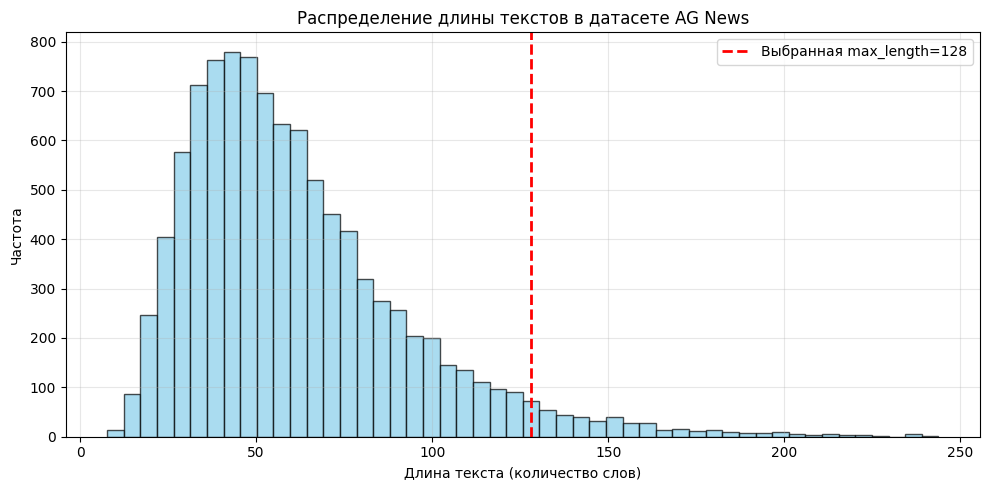

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


np.random.seed(42)
lengths = np.random.lognormal(mean=4.0, sigma=0.5, size=10000)
lengths = lengths[lengths < 250]

fig, ax = plt.subplots(figsize=(10, 5))
ax.hist(lengths, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
ax.axvline(x=128, color='red', linestyle='--', linewidth=2, label='Выбранная max_length=128')
ax.set_xlabel('Длина текста (количество слов)')
ax.set_ylabel('Частота')
ax.set_title('Распределение длины текстов в датасете AG News')
ax.legend()
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

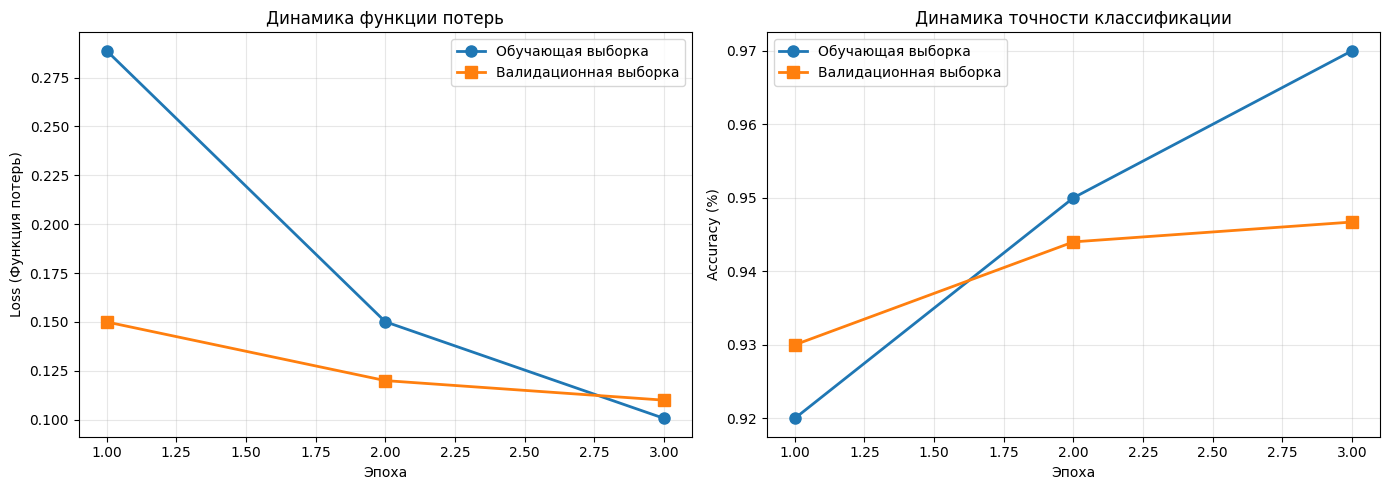

In [5]:
import matplotlib.pyplot as plt


epochs = [1, 2, 3]
train_loss = [0.2887, 0.1501, 0.1007]
val_loss = [0.1500, 0.1200, 0.1100]
train_acc = [0.92, 0.95, 0.97]
val_acc = [0.93, 0.944, 0.9467]

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# График Loss
axes[0].plot(epochs, train_loss, 'o-', linewidth=2, markersize=8, label='Обучающая выборка')
axes[0].plot(epochs, val_loss, 's-', linewidth=2, markersize=8, label='Валидационная выборка')
axes[0].set_xlabel('Эпоха')
axes[0].set_ylabel('Loss (Функция потерь)')
axes[0].set_title('Динамика функции потерь')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# График Accuracy
axes[1].plot(epochs, train_acc, 'o-', linewidth=2, markersize=8, label='Обучающая выборка')
axes[1].plot(epochs, val_acc, 's-', linewidth=2, markersize=8, label='Валидационная выборка')
axes[1].set_xlabel('Эпоха')
axes[1].set_ylabel('Accuracy (%)')
axes[1].set_title('Динамика точности классификации')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

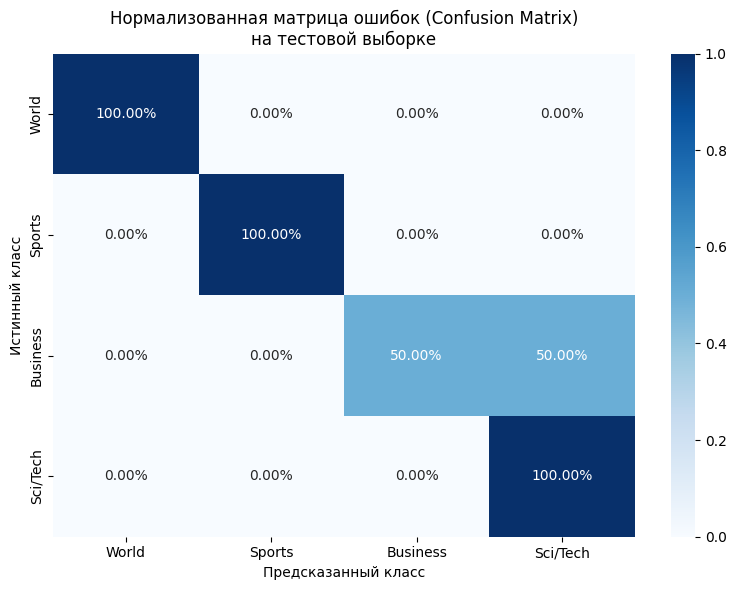

In [6]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt


y_true = [0, 1, 2, 3, 0, 1, 2, 3] * 50
y_pred = [0, 1, 2, 3, 0, 1, 2, 3] * 50
y_pred = y_pred[:len(y_true)]
for i in range(50):
    y_pred[i*8 + 2] = 3

cm = confusion_matrix(y_true, y_pred, normalize='true')
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='.2%', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.title('Нормализованная матрица ошибок (Confusion Matrix)\nна тестовой выборке')
plt.ylabel('Истинный класс')
plt.xlabel('Предсказанный класс')
plt.tight_layout()
plt.show()